When using word vectors, semantically close words will appear to be similar computations within the model, where other words will appear to do different-looking computations. 

# simple procedure for word vectors

* Create data tuples of the format [input word, output word], where each word is represented as one-hot vectors, from raw text
* Define a model that can take in the one-hot vectors as inputs and outputs, to be trained
* Define a loss function that predict the correct word, which is actually in the context of the input word, to optimize the model
* Evaluate the model by making sure similar words have similar word vectors

# Creating structured data from raw text

The cat pushed the glass off the table

The data created from this sentence would look like as follows. Each row after the sentence represents a single data point. The blue box represents the one-hot input word (the middle word, called the target word), and the red box represents the one-hot output word (any word in the context window except the middle word, called context words). Two data points are created from a single context window. The size of the context window is something defined by the user. Higher the context window size, the better the performance of the model. But when having a large context window size, you’ll pay in computational time, as the amount of data increases. Don’t confuse the target word with the target 

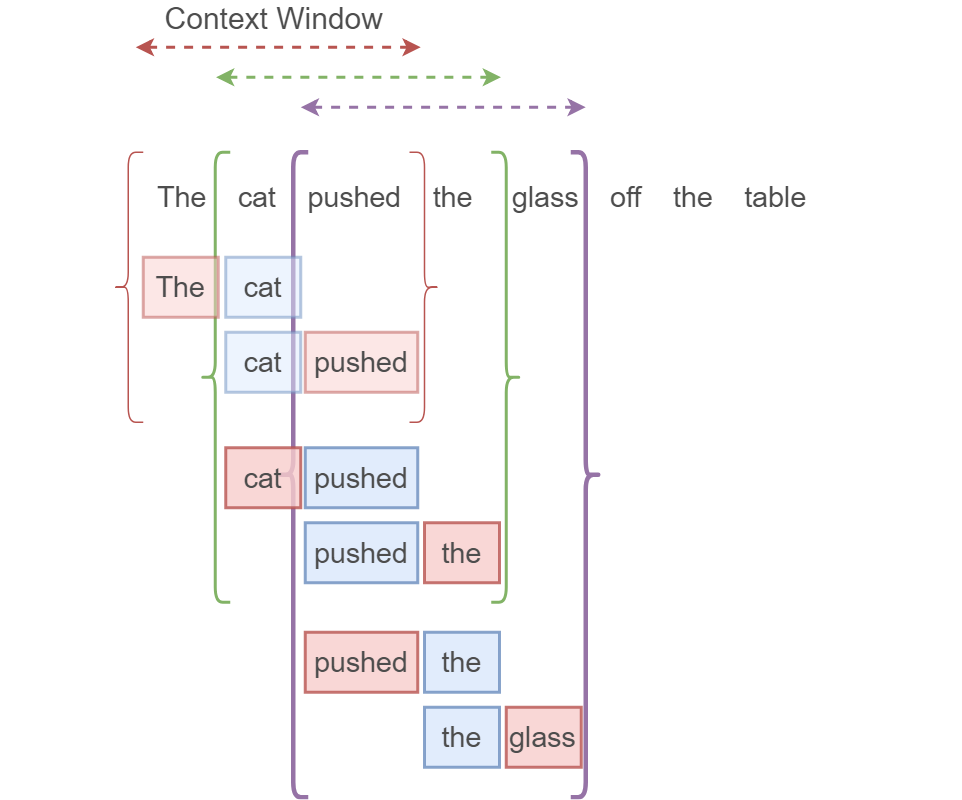

# Defining the embedding layer and the neural network

* A batch of inputs represented as one-hot vectors
* A batch of outputs represented as one-hot vectors (only at training phase)
* An embedding layer
* A neural network

# Embedding layer: stores all the word vectors

The embedding layer stores the word vectors of all the words found in the vocabulary.
As you can imaging this is an enormous matrix (of size [vocabulary size x embedding size]). 

This embedding size is a user-tunable parameter. The higher it is, the better performing your model will be.
But you’ll not get much of a jaw-dropping performance/size gain, beyond a certain point (say, an embedding size of 500).

This matrix is initialized randomly (just like a neural network) and is tweaked bit by bit, during the optimization process, to reveal the powerful word vectors. 

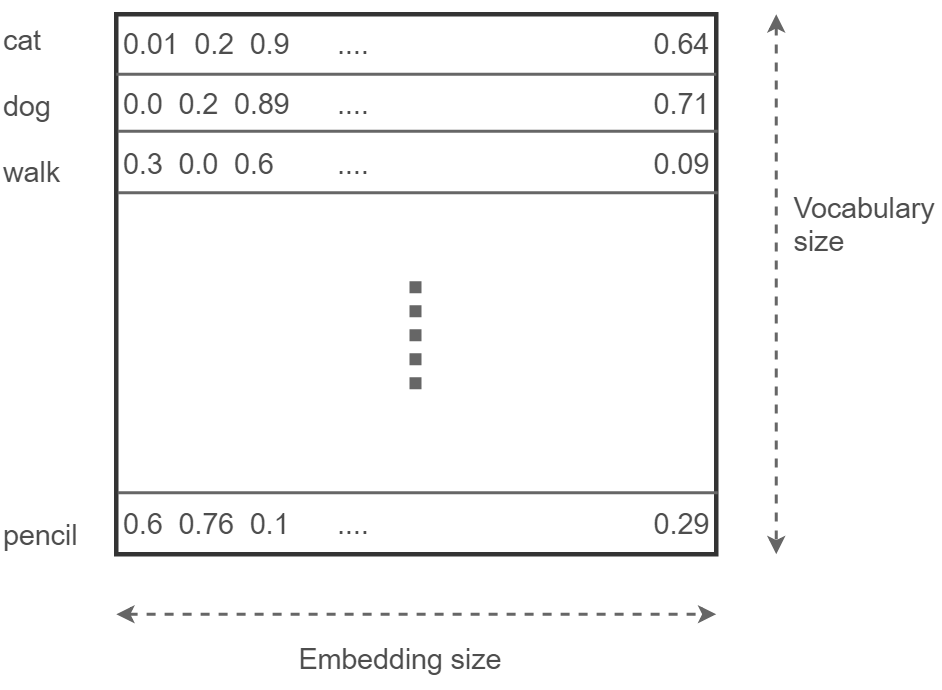

# Neural network: maps word vectors to outputs

During the training, the neural network takes an input word and attempt to predict the output word. Then using a loss function, we penalize the model for incorrect classifications and reward the model for correct classifications.

### the exact process used during training:

* For a given input word (the target word), find the corresponding word vector from the embedding layer
* Feed the word vector to the neural network, then try to predict the correct output word (a context word)
* By comparing the prediction and true context word, compute the loss
* Use the loss along with a stochastic optimizer to optimize the neural network and the embedding layer

use a softmax activation to normalize the predictions to a valid probability distribution.

# Fitting all together: inputs to model to outputs

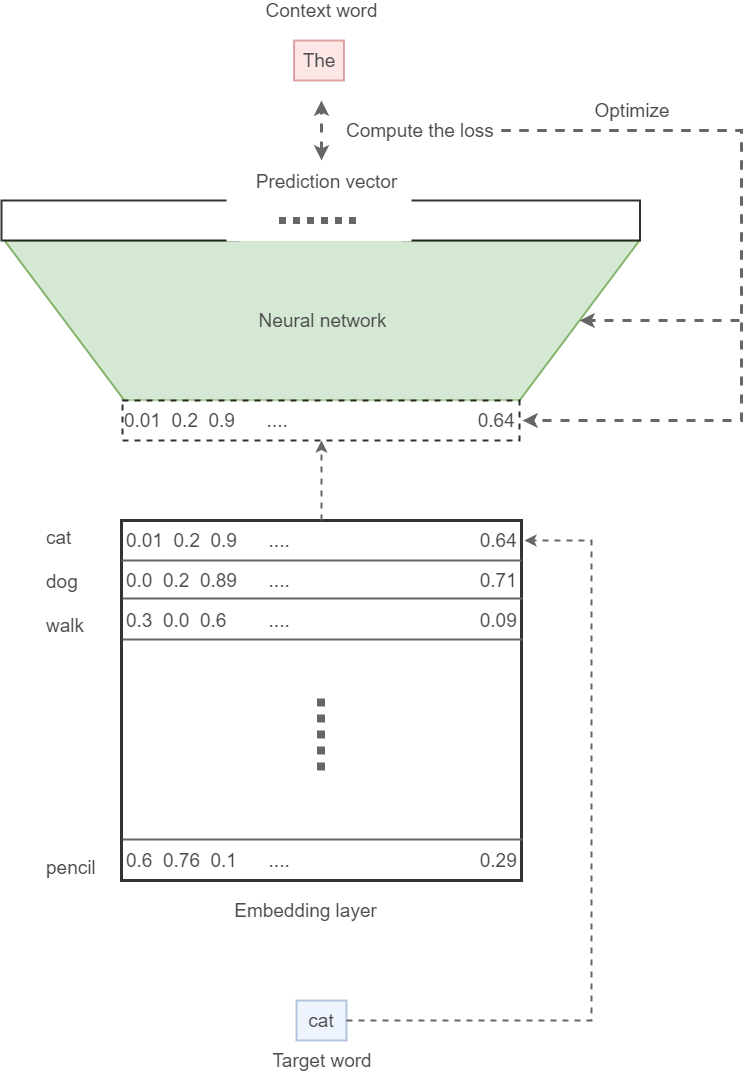

# Defining a loss function: to optimize the model

### softmax cross entropy loss

Normally, standard softmax cross entropy loss is a good loss function for a classification task. Using this loss is not very practical for a Word2vec model, as for a simpler task like sentiment analysis (where you have 2 possible outputs: positive or negative). Here things can get funky. In a real word task, that consumes billions of words, the vocabulary size can grow upto 100,000 or beyond easily. This makes the computation of the softmax normalization heavy. This is because the full computation of softmax require to calculate cross entropy loss with respect to all the output nodes.

### sampled softmax loss

Note that there is quite a lot of changes from the standard softmax cross entropy loss. First, you compute the cross entropy loss between the true context word ID for a given target word and the prediction value corresponding to the true context word ID. Then to that, we add the cross entropy loss of K negative samples we sampled according to some noise distribution. On a high level, we define the loss as follows:

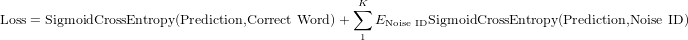

The SigmoidCrossEntropy is a loss we can define on a single output node, independent of the rest of the nodes. This makes it ideal for our problem, as our vocabulary can grow quite large.

the sampled softmax loss computes the loss (e.g. K) by considering two types of entities:


* The index given by the true context word ID in the prediction vector (words within the context window)
* K indices that indicate word IDs, and are considered to be noise (words outside the context window)


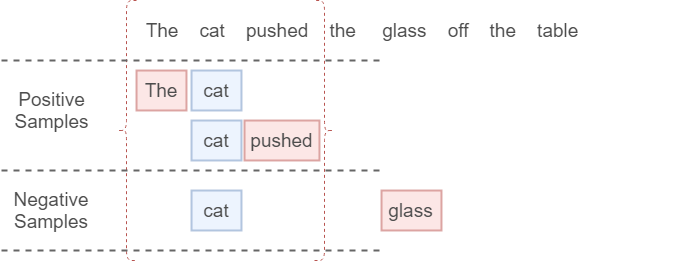

# TensorFlow implementation: skip-gram algorithm

## Library

In [11]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pylab
from sklearn.manifold import TSNE
import operator # sorting items in dictionary by value
from math import ceil

Instructions for updating:
non-resource variables are not supported in the long term


## read the data

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    
    return text

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with open(filename,'r') as f:
        data = []
        file_string = f.read()
        file_string = preprocess_text(file_string)
        file_string = file_string.split(' ')
        data.extend(file_string)
    return data
  
words = read_data('dataset\\pets.txt')
print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Data size 24003
Example words (start):  ['', 'a', 'tabby', 'cat', 'and', 'a', 'mixed', 'molosser', 'dog', 'a']
Example words (end):  ['be', 'injured', 'or', 'killed', 'by', 'a', 'high', 'fall', '282', '']


In [4]:
vocabulary_size = 0

def build_dataset(words):
    global vocabulary_size

    count = [['UNK', -1]]
    # Gets words sorted by frequency
    count.extend(collections.Counter(words).most_common())
    dictionary = dict()

    # Create an ID for each unique word
    for word, c in count:
        if c<10:
            continue
        dictionary[word] = len(dictionary)
        vocabulary_size += 1
    
    data = list()
    unk_count = 0

    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  
            unk_count = unk_count + 1
        data.append(index)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('Vocabulary size: ',vocabulary_size)

Most common words (+UNK) [['UNK', 9628], ('the', 1142), ('of', 765), ('and', 731), ('to', 569)]
Sample data [7, 5, 0, 17, 2, 5, 0, 0, 14, 5]
Vocabulary size:  311


## Data generator

In [5]:
data_index = 0

def generate_batch(batch_size, window_size):
    global data_index 
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span defines the total window size
    span = 2 * window_size + 1 
    
    # The buffer holds the data contained within the span
    queue = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        queue.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size // (2*window_size)):
        k=0
        # Avoid the target word itself as a prediction
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * (2*window_size) + k] = queue[window_size]
            labels[i * (2*window_size) + k, 0] = queue[j]
            k += 1 
    
    # Everytime we read num_samples data points, update the queue
    queue.append(data[data_index])
    
    # If end is reached, circle back to the beginning
    data_index = (data_index + np.random.randint(window_size)) % len(data)
    
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch, labels = generate_batch(batch_size=8, window_size=2)
print('\nwith window_size = %d:' %2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['', 'a', 'the', 'cat', 'and', 'a', 'the', 'the']

with window_size = 2:
    batch: ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
    labels: ['', 'a', 'cat', 'and', '', 'a', 'cat', 'and']


## Defining the skip-gram model

* Hyperparameters (e.g. batch_size)
* Input and output placeholders
* Model parameter: the embedding layer
* Model parameter: the neural network (a softmax layer)
* Loss of the model
* Optimizer for the loss function

In [6]:
batch_size = 128 
embedding_size = 64 
window_size = 4 

num_sampled = 32 # Number of negative examples to sample.

The batch_size defines the number of data points in we process at a given time. 
the embedding_size is the size of a word vector. 
The next hyperparameter window_size defines the size of the context window we visualized above. 
The num_sampled defines the number of negative samples in the loss function (K). 

In [12]:
tf.compat.v1.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# Here the train_dataset takes a list of word IDs of batch_size that represents a selected set of target words. 
# Finally, train_labels represents a batch_size list of corresponding context words for the selected target words. 

################################################
#            Model variables                   #
################################################

# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Neural network weights and biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.1 / math.sqrt(embedding_size))
)
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],-0.01,0.01))

# We have defined the embedding layer as a TensorFlow variable: embeddings. 
# Then we define the neural network weights (softmax_weights) and biases (softmax_biases). 
# Thereafter we define a key operation required to connect the embedding layer to the neural network to jointly optimize the embedding layer and the neural network.

# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)
#embed = tf.nn.dropout(embed, keep_prob=0.8)

# The tf.nn.embedding_lookup function takes our embedding layer as the input and a set of word IDs (train_dataset) 
# and outputs the corresponding word vectors to the variable embed.

################################################
#            Computes loss                     #
################################################
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

# Here the tf.nn.sampled_softmax_loss function takes in a set of weights (softmax_weights), biases (softmax_biases), 
# a set of word vectors corresponding to the word IDs found in train_dataset, IDs of the correct context words (train_labels), 
# number of noise samples (num_sampled) and the size of the vocabulary (vocabulary_size). 

################################################
#            Optimization                      #
################################################
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

# With the output calculation operations and the loss defined, we can define an optimizer to optimize 
# the loss with respect to the parameters of the embeddings layer and the neural network.

################################################
#            For evaluation                    #
################################################
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

# Then we get the normalized embedding layer by making the vector magnitude equal to 1.

## Running skip-gram

In [13]:
num_steps = 250001

# define a session
session = tf.InteractiveSession()

# Initialize the variables in the graph
# initialize all the TensorFlow variables randomly.
tf.global_variables_initializer().run()
print('Initialized')
average_loss = 0

for step in range(num_steps):

    # Generate a single batch of 
    # for a pre-defined number of steps, 
    # we generate batches of data: target words (batch_data) and context words (batch_labels)
    batch_data, batch_labels = generate_batch(
      batch_size, window_size)

    # Optimize the embedding layer and neural network
    # compute loss
    # we optimize the embedding layer and the neural network by running session.run([optimize, loss],...). 
    # get the resulting loss out, to make sure it is decreasing over time
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    # Update the average loss variable
    average_loss += l
    
    # Here, every 5000 steps, we print the average loss, as a visual aid.
    if (step+1) % 5000 == 0:
        if step > 0:
            average_loss = average_loss / 5000
        print('Average loss at step %d: %f' % (step+1, average_loss))
        average_loss = 0

#  get the final embeddings out, which we later use for visualization of certain words.
sg_embeddings = normalized_embeddings.eval()
session.close()

Initialized
Average loss at step 5000: 3.081130
Average loss at step 10000: 2.624371
Average loss at step 15000: 2.567911
Average loss at step 20000: 2.541352
Average loss at step 25000: 2.528386
Average loss at step 30000: 2.516955
Average loss at step 35000: 2.523694
Average loss at step 40000: 2.519096
Average loss at step 45000: 2.507557
Average loss at step 50000: 2.501614
Average loss at step 55000: 2.499558
Average loss at step 60000: 2.501648
Average loss at step 65000: 2.493096
Average loss at step 70000: 2.507265
Average loss at step 75000: 2.486878
Average loss at step 80000: 2.484523
Average loss at step 85000: 2.474080
Average loss at step 90000: 2.493757
Average loss at step 95000: 2.487471
Average loss at step 100000: 2.476616
Average loss at step 105000: 2.480417
Average loss at step 110000: 2.484092
Average loss at step 115000: 2.475029
Average loss at step 120000: 2.472491
Average loss at step 125000: 2.475562
Average loss at step 130000: 2.477804
Average loss at step

## Visualizing word vectors

Here we visualize the word vectors by means of the t-SNE dimensionality reduction technique.

In [14]:
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(sg_embeddings)

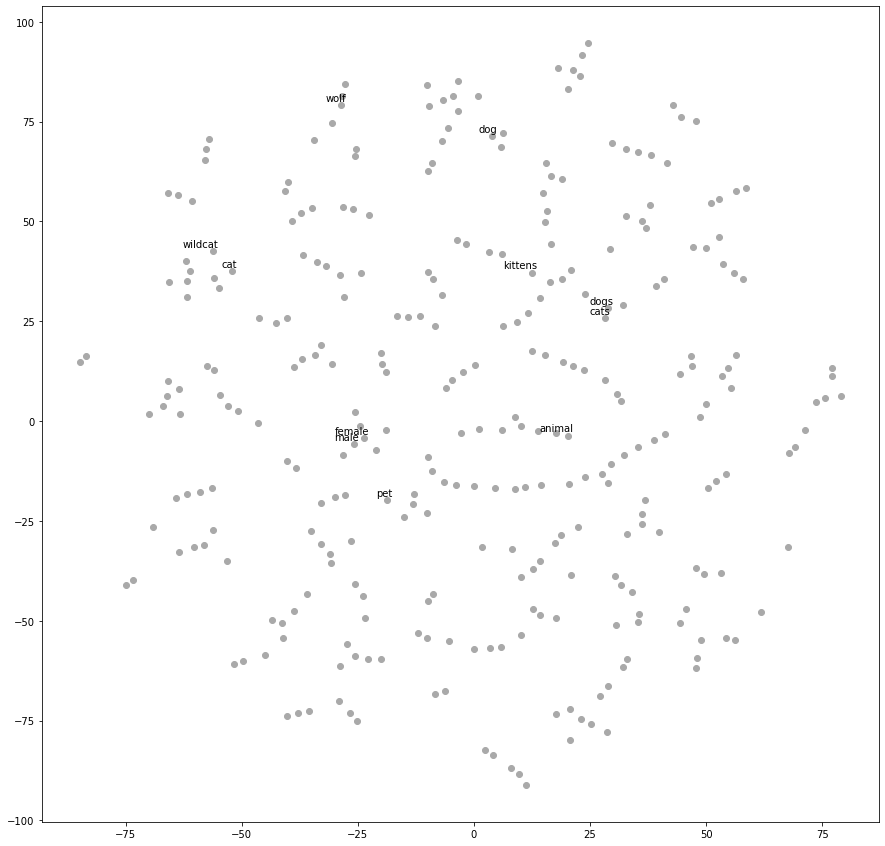

In [16]:
selected_words = ['feline','cat','dog','canary','male','female','animal','pet','wolf','cats','dogs','wildcat','kittens']

words = [reverse_dictionary[i] for i in np.arange(vocabulary_size)]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c='darkgray')   
    if label in selected_words:
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)
        
pylab.show()